<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Introduction](#1)
   - 1.1.[Setup environment](#1.1)
   - 1.2 [Import packages](#1.2)
   - 1.3 [Import data](#1.3)        
2.	[Data preprocessing](#2)
   - 2.1.[Characteristics](#2.1)
   - 2.2 [Interests](#2.2)
   - 2.3 [Mail response](#2.3)
   - 2.4 [Neighborhood](#2.4)
   - 2.5 [Promotion and Gift](#2.5)       
3.	[Data cleanning](#3)
   - 3.1 [Outliers](#3.1)
   - 3.2 [Missing values](#3.2)
   - 3.3 [Data transformation](#3.3)
   - 3.4 [Dimensionality reduction](#3.4)       
4. [Clustering](#4)

# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages** <a class="anchor" id="1.2"></a>

In [147]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram
from scipy import stats


#Outliers: 
from sklearn.neighbors import LocalOutlierFactor


from collections import Counter

#Functions
import OurFunctions as func

## **1.3. Import data** <a class="anchor" id="1.3"></a>

In [2]:
data = pd.read_csv('data/donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


# **2. Pre-processing data:** <a class="anchor" id="2"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [3]:
# Import the database we create for selecting the features:
selected_features_list = pd.read_csv('Selected_Features.csv',index_col=0)
selected_features_list.head()

,FeaturesName,Description,Category,Selected
Index,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,x
2,OSOURCE,Origin Source,Characteristics,x
3,TCODE,Donor title code,Characteristics,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,x


In [4]:
# function to update slected features dataframe everytime we adjust the data
def update_selected_feats_list(df, features_list):
    selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
    return selected_feats

# Get the selected features
selected_feats = selected_features_list[selected_features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()

Next step, we will access each features subset by goinf through 3 steps:
- A) Feature engineering
- B) Unique values check
- C) Correlation check

## **2.1. Characteristics:** <a class="anchor" id="2.1"></a>


In [5]:
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **A) Feature engineering:**

In [6]:
selected_features_list[selected_features_list['Category'] == 'Characteristics']

,FeaturesName,Description,Category,Selected
Index,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,x
2,OSOURCE,Origin Source,Characteristics,x
3,TCODE,Donor title code,Characteristics,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,x
6,MAILCODE,Mail Code,Characteristics,x
8,DOB,"Date of birth (YYMM, Year/Month format.)",Characteristics,x
14,MDMAUD,The Major Donor Matrix code,Characteristics,x
15,DOMAIN,DOMAIN/Cluster code. A nominal or symbolic field.,Characteristics,x


#### **Getting the Age of every donor:**

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [7]:
df['DOB'].head()

CONTROLN
95515     1957-12-01
148535    1972-02-01
15078            NaN
172556    1948-01-01
7112      1940-01-01
Name: DOB, dtype: object

In [8]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list metatada
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","x" ]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

#### **Converting NaN values:**

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [9]:
df[char_feats].isin([' ']).sum(axis = 0)

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
MAILCODE    94013
MDMAUD          0
DOMAIN       2316
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
NUMCHLD         0
INCOME          0
GENDER       2957
WEALTH1         0
HIT             0
MAJOR       95118
WEALTH2         0
GEOCODE     80168
GEOCODE2      187
AGE             0
dtype: int64

In [10]:
# Except for MAILCODE where ' ' is actually a value, we will replace all other ' ' values as NaN
for col in df[char_feats].isin([' ']).sum(axis = 0).index:
    if col == 'MAILCODE':
        next
    else:
        df[col] = df[col].replace(' ', np.NaN)

#### **Converting gender values:**

In [11]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print(df['GENDER'].unique())

['F' 'M' nan 'C' 'U' 'J' 'A']


There are some values that is not described in the metadata, we will assume that these values are Unknown(U) values

In [12]:
#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print(df['GENDER'].unique())

['F' 'M' nan 'U' 'J']


#### **Converting invalid ZIP values:**

In [13]:
#clean all the ZIP values with hifén
df.ZIP = df.ZIP.replace("-","", regex=True)

In [14]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **B) Unique values check:**

In [15]:
# Check for top frequency values
df[char_feats].describe(include=['O'])

,ODATEDW,OSOURCE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,MAJOR,GEOCODE,GEOCODE2
count,95412,94484,95412,95412,95412,95412,93096,73184,1146,1566,1811,2847,92455,294,15244,95093
unique,54,895,57,16488,2,28,16,2,3,3,3,3,4,1,7,4
top,2015-01-01,MBC,CA,85351,,XXXX,R2,H,M,M,M,M,F,X,12,A
freq,15358,4539,17343,64,94013,95118,13623,52354,869,1061,1149,1442,51277,294,3914,34484


In [16]:
# Check for the percentage of the top unique value
func.unique_check_categorical(df[char_feats], 0.9)

MAILCODE , percentage of top unique value = 98.53 %
MDMAUD , percentage of top unique value = 99.69 %
MAJOR , percentage of top unique value = 100.00 %


In [17]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **C) Correlation check:**

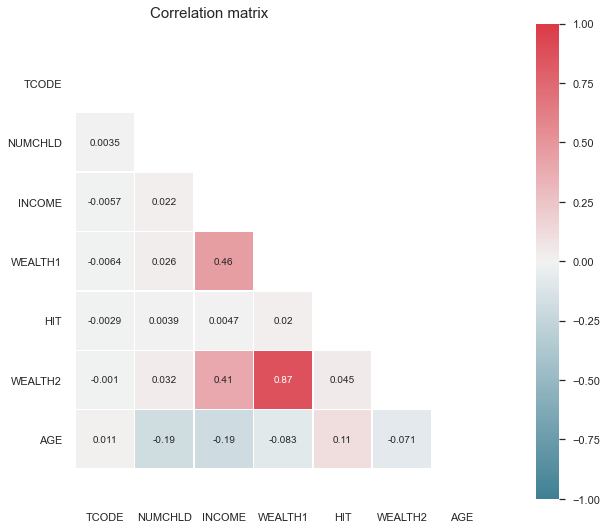

In [18]:
func.corrheatmap(df[char_feats])

There is no significant correlation except for WEALTH1 and WEALTH2

## **2.2. Interest** <a class="anchor" id="2.2"></a>

In [19]:
interests_feats = selected_features_list[selected_features_list['Category'] == 'Interests']['FeaturesName']
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [20]:
df.loc[:, interests_feats].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,,,,,,,,,,,,,,,,,,
148535,,,,,,,,,,,,,,,,,,
15078,,,,,,,,,,,,,,,,,,
172556,,,,,,,,,,,,,,,,,,
7112,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,


In [21]:
#Replace the values for booleans
df.loc[:,interests_feats] = df.loc[:,interests_feats].replace(' ',0)
df.loc[:,interests_feats] = df.loc[:,interests_feats].replace('Y',1)
df.loc[:,interests_feats].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7112,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0


### **B) Unique values check:**

In [22]:
# Plot the result
#plotdf = df.loc[:,interests_feats].apply(pd.value_counts)
#plot pie charts for all the interests
#sns.set()
#fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
#for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
 #   ax.pie(plotdf[feat])
  #  ax.set_title(feat, y=-0.13)
   # ax.legend(plotdf.index)
#plt.show() 

## **2.3. Mail response:** <a class="anchor" id="2.3"></a>

In [23]:
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

In [24]:
df.loc[:,mail_feats]

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,
95515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148535,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
15078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
172556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7112,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122706,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This features subset do not need any further engineering

### **B) Unique values check:**

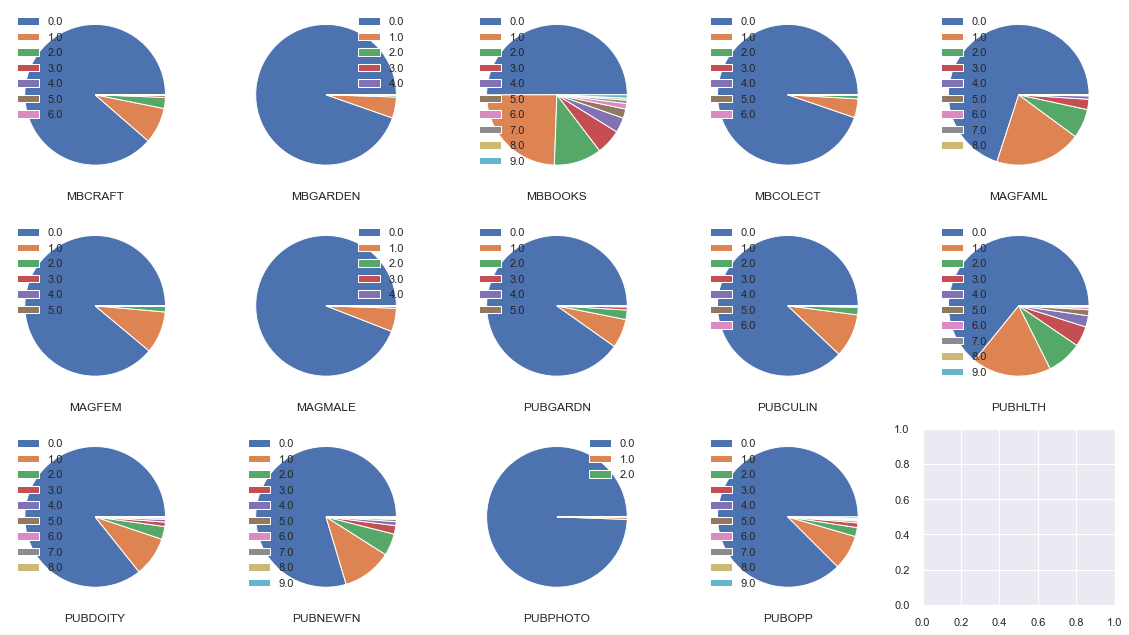

In [25]:
# Plot the result
plotdf = df.loc[:,mail_feats].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat].dropna())
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **C) Correlation check:**

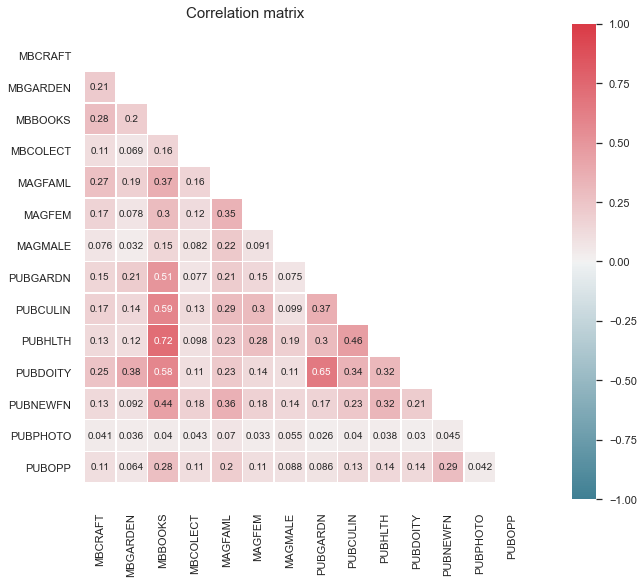

In [26]:
func.corrheatmap(df[mail_feats])

## **2.4. Neighborhood:** <a class="anchor" id="2.4"></a>

In [27]:
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Neighborhood']

,FeaturesName,Description,Category,Selected
54,POP901,Number of Persons,Neighborhood,x
55,POP90C1,Percent Population in Urbanized Area,Neighborhood,x
56,POP90C4,Percent Male,Neighborhood,x
57,ETH1,Percent White,Neighborhood,x
58,ETH2,Percent Black,Neighborhood,x
59,ETH3,Percent Native American,Neighborhood,x
60,ETH4,Percent Pacific Islander/Asian,Neighborhood,x
61,ETH5,Percent Hispanic,Neighborhood,x
62,ETH6,Percent Asian Indian,Neighborhood,x
63,AGE901,Median Age of Population,Neighborhood,x


### **A) Feature engineering:**

In [28]:
df[neighbor_feats].head()

,POP901,POP90C1,POP90C4,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,AGE901,...,HU3,IC2,IC5,TPE10,LFC1,OCC1,EC1,AFC1,AFC4,POBC1
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,992,0,47,92,1,0,0,11,0,39,...,96,318,12883,14,56,9,120,0,18,3
148535,3611,99,50,67,0,0,31,6,4,34,...,97,1096,36175,24,70,22,160,0,8,42
15078,7001,0,49,96,2,0,0,2,0,35,...,93,292,11576,19,65,10,120,0,10,2
172556,640,0,54,61,0,0,11,32,6,32,...,93,388,15130,13,69,17,120,0,13,29
7112,2520,99,46,2,98,0,0,1,0,33,...,97,250,9836,24,61,17,120,1,15,1


This features subset do not need any further engineering

### **B) Unique values check:**

In [29]:
func.unique_check_numerical(df[neighbor_feats], 0.8)

['ETH6', 'AFC1']

In [30]:
func.check_value_counts(df[neighbor_feats])

POP901
0       799
1086     78
923      77
1094     75
834      73
Name: POP901, dtype: int64
-------------------
POP90C1
99    50548
0     35415
98      510
97      453
95      331
Name: POP90C1, dtype: int64
-------------------
POP90C4
49    18086
50    17284
48    14263
51    10067
47     9820
Name: POP90C4, dtype: int64
-------------------
ETH1
99    15689
98     8662
97     7133
96     6092
95     4961
Name: ETH1, dtype: int64
-------------------
ETH2
0    31240
1    18193
2     9336
3     5785
4     4068
Name: ETH2, dtype: int64
-------------------
ETH3
0    62275
1    24419
2     4306
3     1351
4      707
Name: ETH3, dtype: int64
-------------------
ETH4
0    37177
1    23722
2    10555
3     5691
4     3725
Name: ETH4, dtype: int64
-------------------
ETH5
1    22602
0    15803
2    11884
3     6999
4     4690
Name: ETH5, dtype: int64
-------------------
ETH6
0    80799
1    11412
2     1952
3      660
4      275
Name: ETH6, dtype: int64
-------------------
AGE901
33    8125
3

In [31]:
# POP901 = 0 is WEIRD. We have 799 records with 0 people in the neighborhood.

### **C) Correlation check:**

In [32]:
func.correlation_check(df[neighbor_feats],limit = 0.85)

High correlation columns are: ['IC5']


In [33]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']

## **2.5. Promotion and Gift:** <a class="anchor" id="2.5"></a>

In [34]:
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']

,FeaturesName,Description,Category,Selected
81,RFA_3,Donor's RFA status as of 96NK promotion date,Promotion and Gift,x
82,RFA_4,Donor's RFA status as of 96TK promotion date,Promotion and Gift,x
83,RFA_5,Donor's RFA status as of 96SK promotion date,Promotion and Gift,x
84,RFA_6,Donor's RFA status as of 96LL promotion date,Promotion and Gift,x
85,RFA_7,Donor's RFA status as of 96G1 promotion date,Promotion and Gift,x
86,RFA_8,Donor's RFA status as of 96GK promotion date,Promotion and Gift,x
87,RFA_9,Donor's RFA status as of 96CC promotion date,Promotion and Gift,x
88,RFA_10,Donor's RFA status as of 96WL promotion date,Promotion and Gift,x
89,RFA_11,Donor's RFA status as of 96X1 promotion date,Promotion and Gift,x
90,RFA_12,Donor's RFA status as of 96XK promotion date,Promotion and Gift,x


### **A) Feature engineering:**

**Generate RFA status of the each donor before they are considered to be Lapsed Donor:**

Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [35]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1]).astype(int)
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","x"]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')

# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
CONTROLN,,,
95515,S,4,E
148535,A,2,G
15078,S,4,E
172556,S,4,E
7112,A,2,F


**Date-time features:**

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [36]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [37]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","x"]], 
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **B) Unique values check:**

In [38]:
df[PG_feats].describe(include=['O'])

,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,RFA_USEDTO_R,RFA_USEDTO_A
count,95412,95412,95412,95412,95412,95412,95412
unique,1,4,5,4,5,8,7
top,L,F,X,X,X,A,F
freq,95412,46964,95118,95118,95118,60156,46170


In [39]:
func.unique_check_categorical(df[PG_feats], 0.9)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.69 %
MDMAUD_F , percentage of top unique value = 99.69 %
MDMAUD_A , percentage of top unique value = 99.69 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [40]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **C) Correlation check:**

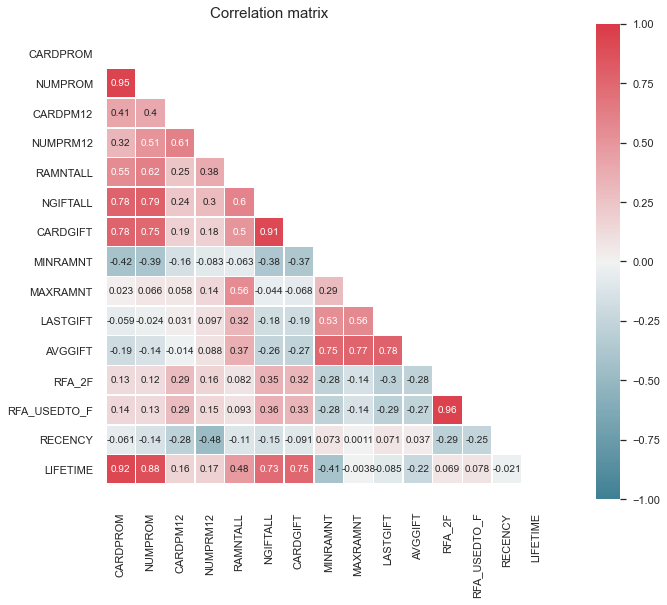

In [41]:
func.corrheatmap(df[PG_feats])

In [42]:
func.correlation_check(df[PG_feats])

High correlation columns are: ['NUMPROM', 'CARDGIFT', 'RFA_USEDTO_F', 'LIFETIME']


In [43]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### Check for data preprocessing result

In [44]:
# Current dataframe
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,DOMAIN,HOMEOWNR,NUMCHLD,INCOME,GENDER,...,LASTGIFT,AVGGIFT,RFA_2F,RFA_2A,GEOCODE2,AGE,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A,RECENCY
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,2009-01-01,GRI,0,IL,61081,T2,NaN,NaN,NaN,F,...,10.0,7.741935,4,E,C,59.0,S,4,E,428.0
148535,2014-01-01,BOA,1,CA,91326,S1,H,1.0,6.0,M,...,25.0,15.666667,2,G,A,45.0,A,2,G,428.0
15078,2010-01-01,AMH,1,NC,27017,R2,U,NaN,3.0,M,...,5.0,7.481481,4,E,C,NaN,S,4,E,428.0
172556,2007-01-01,BRY,0,CA,95953,R2,U,NaN,1.0,F,...,10.0,6.812500,4,E,C,69.0,S,4,E,428.0
7112,2006-01-01,NaN,0,FL,33176,S2,H,1.0,3.0,F,...,15.0,6.864865,2,F,A,77.0,A,2,F,397.0


In [45]:
# Summary features by category
pd.DataFrame(selected_features_list.groupby('Category')['FeaturesName'].count())

,FeaturesName
Category,
Characteristics,16
Interests,18
Mail response,14
Neighborhood,27
Promotion and Gift,15


# **3. Data cleanning:** <a class="anchor" id="3"></a>

In [46]:
# Setting variable:
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']
interest_feats = selected_features_list[selected_features_list['Category'] == 'Interests']['FeaturesName']
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']
neibhbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']


# Assigning categorical and numeric features
PG_feats_categorical = df[PG_feats].loc[:,df[PG_feats].dtypes == 'O'].columns
PG_feats_numeric = df[PG_feats].loc[:,df[PG_feats].dtypes != 'O'].columns
PG_feats_numeric = PG_feats_numeric.drop(['RFA_2F','RFA_USEDTO_F'])
PG_feats_categorical = np.append(PG_feats_categorical,['RFA_2F','RFA_USEDTO_F'])

## **3.1. Check for non-sense data :** <a class="anchor" id="3.1"></a>

At this part, we will try to identify and clear the observations that is not possible to be recorded with subjective intuition. These kind of observations can be identified using `describe()` method and some other understanding of the features on the basis level. We also carry out some research on the features themselves in order to be as most objective as possible in our desicion.

3.1.1. Characteristics features subset:

In [47]:
df[char_feats].describe()

,TCODE,NUMCHLD,INCOME,WEALTH1,HIT,WEALTH2,AGE
count,95412.000000,12386.000000,74126.000000,50680.000000,95412.000000,51589.000000,71529.000000
mean,54.223117,1.527773,3.886248,5.345699,3.321438,4.954525,58.376043
std,953.844476,0.806861,1.854960,2.742490,9.306899,2.802759,16.725625
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,2.000000,3.000000,0.000000,3.000000,46.000000
50%,1.000000,1.000000,4.000000,6.000000,0.000000,5.000000,59.000000
75%,2.000000,2.000000,5.000000,8.000000,3.000000,7.000000,73.000000
max,72002.000000,7.000000,7.000000,9.000000,241.000000,9.000000,87.000000


Here we notice that AGE features have the minimum value of -1 which is clearly impossible, thus we decide to drop these obseravation.

In [48]:
#dropping invalid age values
print('Number of invalid observations:', len(df[(df.AGE <= 0)]))
#dropping invalid age values
df = df[~(df.AGE <= 0)]

Number of invalid observations: 13


3.1.2. Neighborhood features subset:

In [49]:
df[neighbor_feats].describe()

,POP901,POP90C1,POP90C4,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,AGE901,...,HU3,IC2,IC5,TPE10,LFC1,OCC1,EC1,AFC1,AFC4,POBC1
count,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,...,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000,95399.000000
mean,3256.087821,58.588298,48.211868,84.853562,7.467825,0.776979,2.905838,7.458579,0.215988,34.474953,...,89.966425,387.026971,15722.584618,19.480749,64.531987,14.122423,128.021782,0.596516,15.574241,6.625111
std,5743.554329,47.430864,5.565894,21.014962,16.691670,3.469546,7.070198,13.786839,0.679248,8.335039,...,12.955908,173.615753,8563.828315,6.773020,13.601058,8.231127,17.736020,3.169537,5.270426,9.646520
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,990.000000,0.000000,47.000000,82.000000,0.000000,0.000000,0.000000,1.000000,0.000000,30.000000,...,89.000000,274.000000,10788.000000,15.000000,59.000000,8.000000,120.000000,0.000000,12.000000,1.000000
50%,1565.000000,99.000000,49.000000,93.000000,1.000000,0.000000,1.000000,2.000000,0.000000,33.000000,...,94.000000,355.000000,13727.000000,19.000000,66.000000,13.000000,120.000000,0.000000,15.000000,3.000000
75%,3091.000000,99.000000,50.000000,98.000000,6.000000,1.000000,3.000000,7.000000,0.000000,37.000000,...,96.000000,465.000000,18168.000000,23.000000,73.000000,18.000000,140.000000,0.000000,19.000000,8.000000
max,98701.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,22.000000,84.000000,...,99.000000,1500.000000,174523.000000,90.000000,99.000000,99.000000,170.000000,97.000000,99.000000,99.000000


Using the same method, we can identify several features having invalid values:
- `AGE901 - Median age of the population`: Having '0' values
- `HHP2 - Average Person Per Household`: Having '0' values
- `EC1 - Median Years of School Completed by Adults 25+`: Having invalid range of values

In [50]:
#dropping invalid age values
print('Number of invalid observations:', len(df[(df.AGE901 <= 0)])+ len(df[(df.HHP2 == 0)]))
#dropping invalid age values
df = df[~(df.AGE901 <= 0)]

#dropping row for places with Average Person Per Household = 0
df = df[~(df.HHP2 == 0)]

Number of invalid observations: 1616


In [51]:
#according to the census the county of Kalawao is the less populated with 88 habitants so we will drop all the records with "Number of habitants" less than that
# df = df[~(df.POP901 <= 87)]

In [52]:
print(df.EC1.describe())

count    94582.000000
mean       129.054344
std         13.469160
min         89.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        170.000000
Name: EC1, dtype: float64


In [53]:
#based on this statistic we can see that the column related to 'Median Years of School Completed by Adults 25+' has no valid values so we will drop it
df.drop('EC1', axis=1,inplace=True,errors='ignore')
neibhbor_feats = neibhbor_feats[neibhbor_feats != 'EC1']

3.1.3. Promotion & Gift:

In [54]:
df = df[df['RECENCY']>0]

## **3.2. Outliers:** <a class="anchor" id="3.2"></a>

In [55]:
#metric_features = df[['AGE','AGE901','POP901','POP90C1','POP90C4','ETH1', 'ETH2', 'ETH3','ETH4','ETH5','ETH6','MARR1', 'MARR2', 'MARR3','MARR4','HHP2', 'HV1', 'HV3','HU3','IC2', 'IC5', 'TPE10','LFC1','OCC1','EC1', 'AFC1', 'AFC4','POBC1']].columns.tolist()

### Numeric Variables' Univariate Distribution

In [56]:
# All Numeric Variables' Histograms in one figure
#sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
#fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(45, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
#for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
 #   ax.hist(df[feat])
  #  ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
#title = "Numeric Variables' Histograms"

#plt.suptitle(title)

#plt.savefig('numeric_variables_histograms.png')
#plt.show()

In [57]:
# All Numeric Variables' Box Plots in one figure
#sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
#fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(45, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
#for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
#    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
#title = "Numeric Variables' Box Plots"

#plt.suptitle(title)

#plt.savefig('numeric_variables_boxplots.png')
#plt.show()

### Pairwise Relationship of Numerical Variables

In [58]:
# Pairwise Relationship of Numerical Variables
#sns.set()

# Setting pairplot
#sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

#plt.savefig('pairwise_relationship_of_numerical_variables.png')
#plt.show()

<img src="pairwise_relationship_of_numerical_variables.png">

## Multivariate outliers:

### Local outlier factor

In [59]:
clf = LocalOutlierFactor(n_neighbors=500, contamination="auto")
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
# Transform with standard scaler
df_lof = StandardScaler().fit_transform(df[PG_feats_numeric])
# Now predict the outliers
y_pred = clf.fit_predict(df_lof)
# Save the score
X_scores = pd.Series(clf.negative_outlier_factor_,index = df[PG_feats_numeric].index)

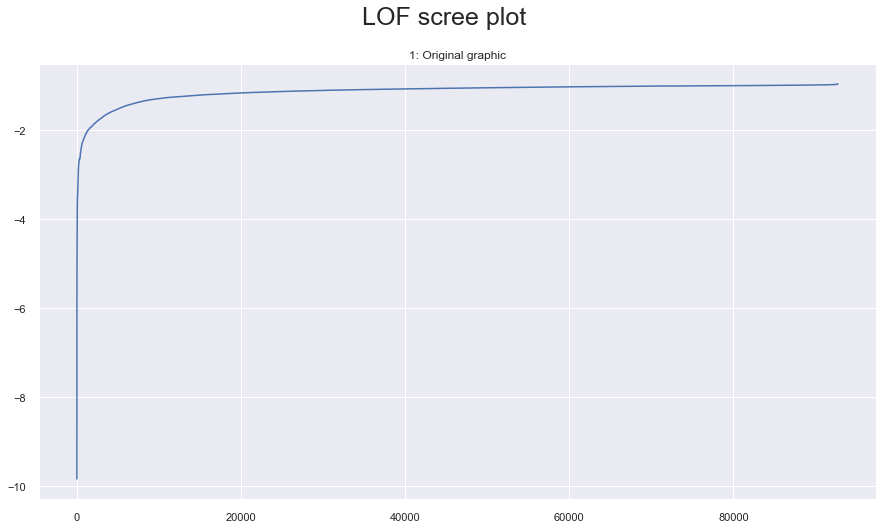

In [60]:
sns.set()
#figure
fig,ax = plt.subplots(figsize=(15,8))
fig.suptitle("LOF scree plot", fontsize=25)

#data
ax.plot(np.sort(X_scores[(X_scores<0)&(X_scores>-10)]))

#layout
ax.set_title("1: Original graphic")
plt.subplots_adjust(hspace=0.3)

plt.show()

From the LOF scree plot, we can confirm that the outlier can be the observations that have the LOF negative score below -2. we will save this mask of outliers for later consideration

In [61]:
PG_feats_outlier_lof = X_scores[(X_scores<-2)].index

#### DBSCAN

In [62]:
# K-distance graph to find out the right eps value
#neigh = NearestNeighbors(n_neighbors=20)
#df_DBSCAN = StandardScaler().fit_transform(df[PG_feats_numeric])
#neigh.fit(df_DBSCAN)
#distances, _ = neigh.kneighbors((df_DBSCAN))

In [63]:
#distances_50 = np.sort(distances[:, -1])[:-50]
#plt.plot(distances_50)
#plt.show()

In [64]:
# Perform DBSCAN clustering
#dbscan = DBSCAN(eps=2, min_samples=20, n_jobs=-1)
#dbscan_labels = dbscan.fit_predict(df_DBSCAN)

#dbscan_n_clusters = len(np.unique(dbscan_labels))
#print("Number of estimated clusters : %d" % dbscan_n_clusters)

In [65]:
# Concatenating the labels to df
#df_concat = pd.concat([df[numeric], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
#df_concat.groupby('dbscan_labels').count()

## **3.2. Missing values (KNN Imputer):** <a class="anchor" id="3.2"></a>

In [66]:
#checking the columns with more null values
df.isnull().sum().sort_values(ascending=False)[:25]
#we will focus on the AGE and INCOME column to not create a big bias

NUMCHLD     81492
GEOCODE     78797
MBCOLECT    51750
PUBGARDN    51690
MBCRAFT     51690
PUBOPP      51690
PUBPHOTO    51690
PUBNEWFN    51690
PUBDOITY    51690
PUBHLTH     51690
PUBCULIN    51690
MAGMALE     51690
MAGFEM      51690
MAGFAML     51690
MBGARDEN    51690
MBBOOKS     51690
WEALTH1     43658
WEALTH2     43001
AGE         23254
HOMEOWNR    21436
INCOME      20648
GENDER       2864
DOMAIN       2186
OSOURCE       868
GEOCODE2       73
dtype: int64

In [67]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
#df[['AGE','INCOME']] = knn_imputer.fit_transform(df[['AGE','INCOME']])

In [68]:
#rounding the new values to have integer
#df[['AGE','INCOME']] = df[['AGE','INCOME']].round()

## **3.3. Data transformation:** <a class="anchor" id="3.3"></a>

### 3.1.5. Promotion and Gift features:

In [69]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

def log10_transformer(df, columns):
    df_out = df.copy()
    for col in columns:
        # we add 1 to the value because some of the columns might contain 0 and they will make the logarithm to result infinity
        df_out.loc[:,col] = np.log10(df.loc[:,col]+1)
        df_out = df_out.rename(columns={col:'LOG_'+col})
    #df = df.drop(columns = columns)
    return df_out

def boxplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    sns.despine(bottom=True)
    plt.show()

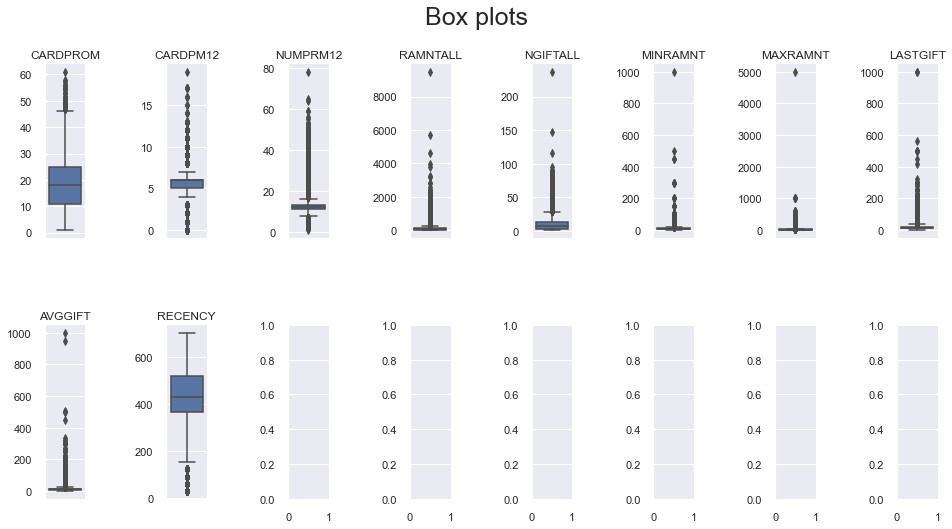

In [70]:
boxplot_func(df[PG_feats_numeric])

- In the boxplots showed above, we can clearly see that the distribution of the these features are highly skewed and maybe contain outliers. In the following steps, we will consider multiple techniques to transform the dataset in order to making it more Gausian-like and identify the outliers

In [71]:
# Box-cox transformation
t_boxcox = PowerTransformer(method='box-cox')
df_transform_boxcox = t_boxcox.fit_transform(df[PG_feats_numeric]+1)
# Yeo-johnson transformation
t_yeojohnson = PowerTransformer(method='yeo-johnson')
df_transform_yeojohnson = t_yeojohnson.fit_transform(df[PG_feats_numeric])
# Quantile transformation
t_quantile = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=0)
df_transform_quantile = t_quantile.fit_transform(df[PG_feats_numeric])
# Logarithm transformation
df_transform_log = log10_transformer(df[PG_feats_numeric], PG_feats_numeric)

In [72]:
def kmeans_R2(df,clusters):
# Apply the cluster
    kmclust = KMeans(n_clusters=clusters, init="k-means++", n_init=20, random_state=1)
    kmclust.fit(df)
    # the predict method
    KM_labels = kmclust.predict(df)
    # Concatenating the labels to df
    df_concat = pd.concat([df, pd.Series(KM_labels, index=df.index, name="KM_labels")], axis=1)
    # Computing the R^2 of the cluster solution
    sst = get_ss(df)  # get total sum of squares
    ssw_labels = df_concat.groupby(by='KM_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2_ = ssb / sst
    print("Cluster solution with R^2 of %0.4f" % r2_)
    return

#scaler = StandardScaler()
#scaled_normal = pd.DataFrame(scaler.fit_transform(df[PG_feats_numeric]), index=df[PG_feats_numeric].index, columns=df[PG_feats_numeric].columns)
#scaled_boxcox = pd.DataFrame(scaler.fit_transform(df_transform_boxcox), index=df[PG_feats_numeric].index, columns=df[PG_feats_numeric].columns)
#scaled_yeo_johnson = pd.DataFrame(scaler.fit_transform(df_transform_yeojohnson), index=df[PG_feats_numeric].index, columns=df[PG_feats_numeric].columns)
#scaled_quantile = pd.DataFrame(scaler.fit_transform(df_transform_quantile), index=df[PG_feats_numeric].index, columns=df[PG_feats_numeric].columns)
#scaled_log = pd.DataFrame(scaler.fit_transform(df_transform_log), index=df_transform_log.index, columns=df_transform_log.columns)


#kmclust = KMeans(init="k-means++", n_init=20, random_state=1)
#r2_scores = {}
#r2_scores['kmeans_normal'] = get_r2_scores(scaled_normal, kmclust)
#r2_scores['kmeans_log'] = get_r2_scores(scaled_log, kmclust)
#r2_scores['kmeans_boxcox'] = get_r2_scores(scaled_boxcox, kmclust)
#r2_scores['kmeans_yeo_johnson'] = get_r2_scores(scaled_yeo_johnson, kmclust)
#r2_scores['kmeans_quantile'] = get_r2_scores(scaled_quantile, kmclust)

In [73]:
#pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

#plt.title("Transformation methods:\nR2 plot for various transformation methods\n", fontsize=21)
#plt.legend(title="Cluster methods", title_fontsize=11)
#plt.xlabel("Number of clusters", fontsize=13)
#plt.ylabel("R2 metric", fontsize=13)
#plt.show()

<img src="Transformation_methods_R2.png">

From the above plot, we can conclude that the logarithm 10 transformation reserve the most R2 score. Thus we decide to use log10 transformation on the data

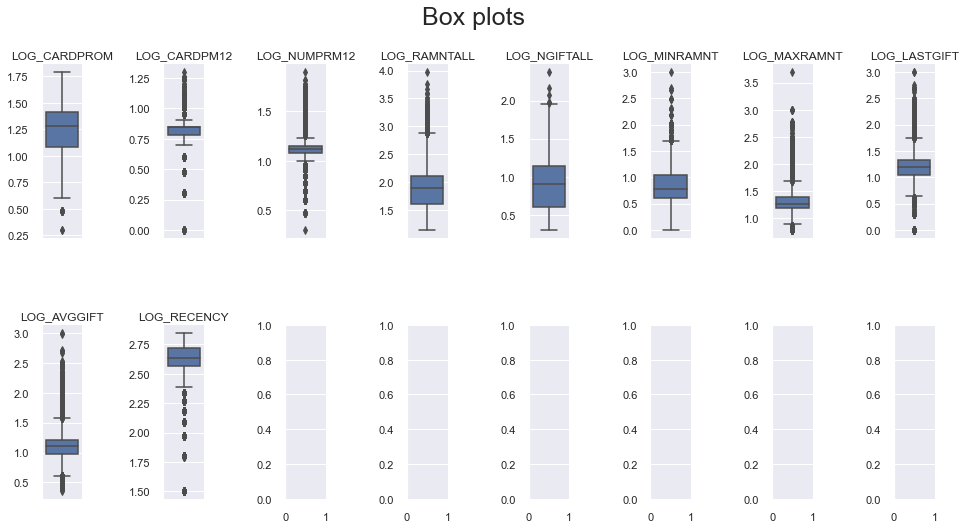

In [74]:
# Transformed with log10
boxplot_func(df_transform_log)

From the boxplot, there is posibility that the distribution of some features have quite low variance and maybe have high kurtosis. Thus, we will check for the Kurtosis value of each features so verify this assumption.

In [75]:
from scipy.stats import kurtosis, skew
from IPython.display import display_html

def distribution_check(df):
    kur = {}
    skewness = {}
    for col in df.columns:
        if df[col].dtype != 'O':
            kur[col] = kurtosis(df[col], fisher=True)
            skewness[col] = skew(df[col])
    kur_df = pd.DataFrame.from_dict(kur, orient='index',columns=['Kurtosis'])
    skew_df = pd.DataFrame.from_dict(skewness, orient='index',columns=['Skewness'])
    return pd.concat([skew_df,kur_df],axis = 1)

def display_side_by_side(*args):
    '''Source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side'''
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Check for the transformation:
display_side_by_side(distribution_check(df[PG_feats_numeric]),distribution_check(df_transform_log))

,Skewness,Kurtosis
CARDPROM,0.146067,-0.947090
CARDPM12,0.194285,4.746901
NUMPRM12,2.974790,13.421804
RAMNTALL,13.205141,660.298327
NGIFTALL,2.063960,11.626976
MINRAMNT,24.141201,2046.955291
MAXRAMNT,108.429973,21635.571268
LASTGIFT,16.327836,759.326754
AVGGIFT,25.545168,1804.750437
RECENCY,-0.304900,1.819310


It is clear from the result above that transforming  `CARDPM12` and `RECENCY` features generate worse result in term of both skewness and kurtosis value.
Hence, we will not transfrom these features with logarithm transformation for clustering

In [76]:
log10_transformer(df[PG_feats_numeric], PG_feats_numeric.drop(['CARDPM12','RECENCY']))

,LOG_CARDPROM,CARDPM12,LOG_NUMPRM12,LOG_RAMNTALL,LOG_NGIFTALL,LOG_MINRAMNT,LOG_MAXRAMNT,LOG_LASTGIFT,LOG_AVGGIFT,RECENCY
CONTROLN,,,,,,,,,,
95515,1.447158,6,1.176091,2.382017,1.505150,0.778151,1.113943,1.041393,0.941608,428.0
148535,1.113943,6,1.146128,1.681241,0.602060,1.041393,1.414973,1.414973,1.221849,428.0
15078,1.431364,6,1.176091,2.307496,1.447158,0.477121,1.230449,0.778151,0.928472,428.0
172556,1.447158,6,1.176091,2.041393,1.230449,0.477121,1.079181,1.041393,0.892790,428.0
7112,1.643453,10,1.414973,2.406540,1.579784,0.602060,1.204120,1.204120,0.895691,397.0
...,...,...,...,...,...,...,...,...,...,...
184568,0.845098,5,1.113943,1.414973,0.301030,1.414973,1.414973,1.414973,1.414973,366.0
122706,0.698970,3,0.954243,1.322219,0.301030,1.322219,1.322219,1.322219,1.322219,337.0
189641,1.176091,7,1.255273,1.770852,0.903090,0.602060,1.041393,1.041393,0.967815,123.0


## **3.4. Dimensionality reduction:** <a class="anchor" id="3.4"></a>

# **4. Clustering:** <a class="anchor" id="4"></a>

## 4.4. Donors' behavior analysis: <a class="anchor" id="4.4"></a>

In this section, we will try to cluster with features representing the behaviour of the donors. These features are the summary features from the promotions sent by the PVA and the donation activities of the donors.

In [77]:
df_PG_feats = log10_transformer(df[PG_feats_numeric], PG_feats_numeric.drop(['CARDPM12','RECENCY']))
PG_feats_numeric_final = df_PG_feats.columns
df_PG_feats.head()

,LOG_CARDPROM,CARDPM12,LOG_NUMPRM12,LOG_RAMNTALL,LOG_NGIFTALL,LOG_MINRAMNT,LOG_MAXRAMNT,LOG_LASTGIFT,LOG_AVGGIFT,RECENCY
CONTROLN,,,,,,,,,,
95515,1.447158,6,1.176091,2.382017,1.505150,0.778151,1.113943,1.041393,0.941608,428.0
148535,1.113943,6,1.146128,1.681241,0.602060,1.041393,1.414973,1.414973,1.221849,428.0
15078,1.431364,6,1.176091,2.307496,1.447158,0.477121,1.230449,0.778151,0.928472,428.0
172556,1.447158,6,1.176091,2.041393,1.230449,0.477121,1.079181,1.041393,0.892790,428.0
7112,1.643453,10,1.414973,2.406540,1.579784,0.602060,1.204120,1.204120,0.895691,397.0


In [78]:
def clusters_score(df, range_clusters = (2, 8)):
    '''Reference: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad'''
    metric_name = ['distortion','Davies Bouldin', 'calinski_harabasz']
    db_score = []
    model = KMeans(init='k-means++', n_init=15)
    # measure Davies Bouldin score
    for n_clus in range_clusters:  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        labels_db = kmclust.fit_predict(df)    
        db_score.append(davies_bouldin_score(df, labels_db))
    db_score = pd.Series(db_score, index = range_clusters)
    # The score plots
    sns.set()
    fig, axes = plt.subplots(1,3, constrained_layout=True, figsize=(12,5))
    fig.suptitle("Elbow plot for each features\n", fontsize=25)
    # Draw nested boxplots
    
    for metric, ax in zip(metric_name, axes.flatten()):
        if  metric == 'Davies Bouldin':
            sns.lineplot(data=db_score, ax=ax )
            sns.despine(offset=10, trim=True,ax = ax)  
        else: 
            visualizer = KElbowVisualizer(model, k=range_clusters, metric=metric, timings= False, locate_elbow=False, ax=ax)
            visualizer.fit(df)        # Fit the data to the visualizer
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel("Metrics")
        #ax.tick_params(axis='x',labelsize = 'small') 
        ax.set_title(metric)   
        
    plt.show()    

In [79]:
# Function to plot boxplot for each features based on clusters
def boxplot_df(df, labels):
    # Concatenate the dataframe with the labels
    df_concat = pd.concat((df, pd.Series(labels, name='labels', index = df.index)), axis=1)
    # Set up figure
    rows = math.ceil(df.shape[1]/4)
    sns.set()
    fig, axes = plt.subplots(rows,4, constrained_layout=True, figsize=(24,4*rows))
    fig.suptitle("Box plot for each features\n", fontsize=25)
    # Draw nested boxplots
    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(x='labels', y=col, data=df_concat, ax=ax )
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x',labelsize = 'small') 
        ax.set_title(col)  

In [80]:
def meanplot_df(df, labels):
    df_concat = pd.concat((df, pd.Series(labels, name='labels',index = df.index)), axis=1)
    plot_data = df_concat.groupby('labels').mean()
    # Plot PCA data
    fig, ax = plt.subplots(figsize = (24,12))
    ax = sns.lineplot(data = plot_data.T)
    plt.show()  

In [81]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    This function calculates the silhouette coefficient for each observation according to a clustering solution and then builds the 
    Silhouette plots for a given range of cluster solutions. This is useful to find out the most appropriate number of clusters.
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))
    
    sns.set()
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # in case we want to seed the silhouette for just one cluster solution
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # Get parameter that defines number of clusters
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Estimator has no parameter to define number of clusters")
            return None
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # initialize y_lower
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("{} Clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette Coefficients")
        ax.set_ylabel("Cluster Labels")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette") # The vertical line for average silhouette score of all the values
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average Silhouette = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Clustering Silhouette Plots"), fontsize=23, fontweight='bold')
    plt.show()

In [82]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def dendogram_hclust(hclust, threshold = 50):
    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = threshold
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()


In [83]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color
    
class PCA_combined(object):
    def __init__(self, df):
        self.df = df
        self.n_components = df.shape[1]

    def Explained_variance(self):
        pca = PCA()
        pca_feat = pca.fit_transform(self.df)
        metrics = pd.DataFrame(
                                {"Eigenvalue": pca.explained_variance_,
                                "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
                                "Proportion": pca.explained_variance_ratio_,
                                "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
                                index=range(1, pca.n_components_ + 1))
        return metrics

    def PCA_test(self, n_components):
        pca = PCA(n_components = n_components)
        pca_feat = pca.fit_transform(self.df)
        self.pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
        self.pca_df_ = pd.DataFrame(pca_feat, index=self.df.index, columns=self.pca_feat_names)  # remember index=df_pca.index
        #Concat to the original value
        self.concat_pca_df_ = pd.concat([self.df, self.pca_df_], axis=1)

    def corr_PCA(self):
        loadings = self.concat_pca_df_.corr().loc[self.df.columns, self.pca_feat_names]
        return loadings

### 4.4.1. K-means clustering:

https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

In [84]:
#clusters_score_withsil(df_scaled)

In [85]:
# Scale the data with standard scaler
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_PG_feats),index = df_PG_feats.index, columns=PG_feats_numeric_final)

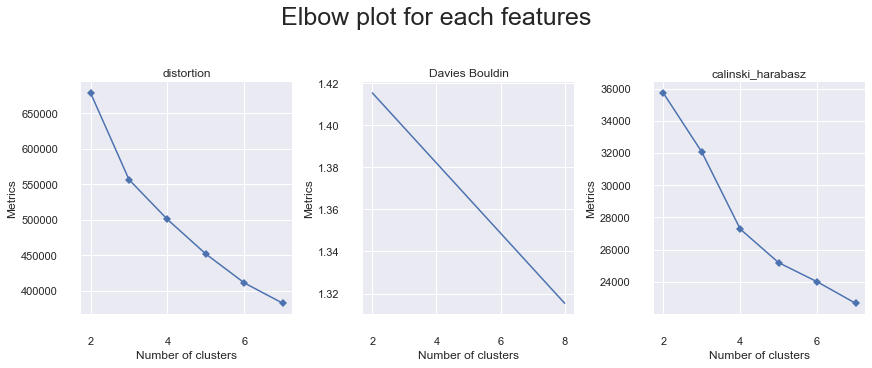

In [86]:
# plot the elbow plot
clusters_score(df_scaled)

In [87]:
kmeans_model = KMeans(n_init=10, max_iter=300, tol=0.001)
# PLot silhouette coefficence score
#silhouette_analysis(df_scaled, estimator = kmeans_model, shape = (3,2), figsize = (16,16), max_nclus = 6, min_nclus=2, dist="euclidean")

<img src="Silhouette_Kmeans.png">

In [175]:
# Now lets measure the R2 with 3 clusters
kmeans_R2(df_scaled,3)

Cluster solution with R^2 of 0.4062


### 4.4.2. Self-organizing map and K-means:

In [121]:
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    # TO-DO 
    data = df_scaled.values,
    mapsize=(20,20),
    lattice='hexa',
    initialization='random',
    neighborhood='gaussian',
    name='sompy',
    training='batch',
    component_names=df_scaled.columns
)

sm.train(n_job=-1, verbose=0, train_rough_len=100, train_finetune_len=100)

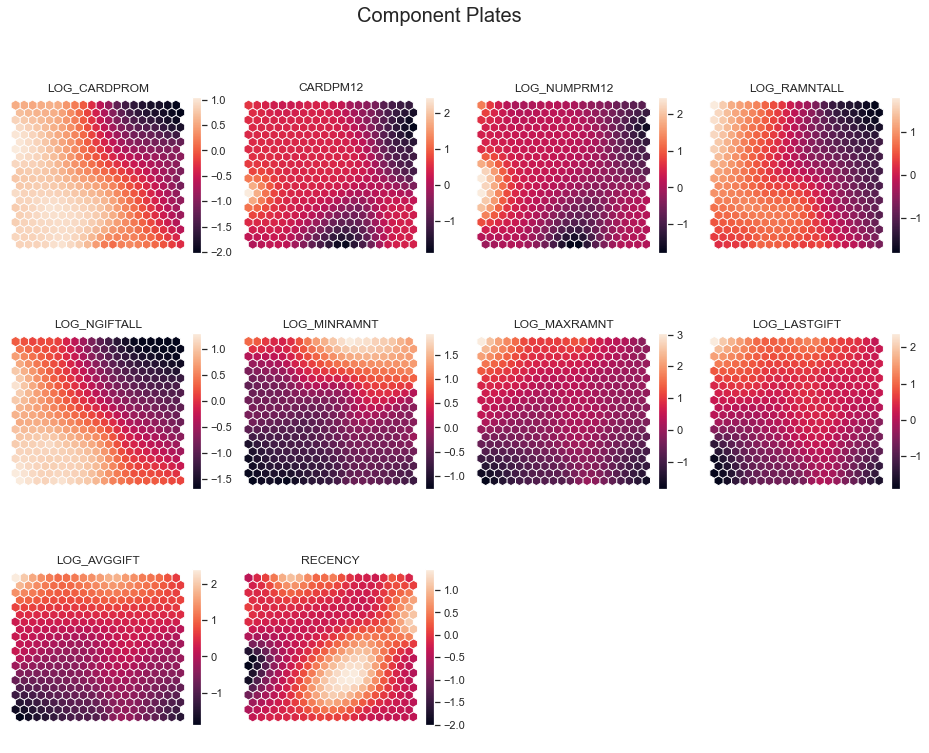

In [134]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=4, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

From the component plant, we are able to carry out some analysis:
- `CARDPROM` has clusters distributed quite similar with `NGIFTALL`, both of them will have opposite values comparing to `MINRANMT`
- `LASTGIFT`, `AVGGIFT` and `MAXRAMNT` have clusters distributed quite similar with each other  
</br>  

Hence, there are some insights about the clusters:
- People who receive less promotion cards will tend to give less in terms of quantity and amount. However, the minimum amount of their gift is considerably high comparing to the others. 
- In contrast, the more promotion cards received, the more people tend to response to it with a donation
- However, an interesting point is that people who receive the most number of promotion cards will tend to give less in terms of amount of minimum, maximum, average and last donation.

In [126]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=22)

nodeclus_labels = sm.cluster(kmeans)

# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=PG_feats_numeric_final)
df_nodes['label'] = nodeclus_labels

# Obtaining SOM's BMUs labels
df_bmus = pd.DataFrame(
    np.concatenate((df_scaled, np.expand_dims(sm._bmu[0],1)), axis=1),
                    index=df_scaled.index, columns=np.append(df_scaled.columns,"BMU")
)
# Get cluster labels for each observation
df_SOM_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True).drop('BMU',axis = 1)
df_SOM_final.head()

,LOG_CARDPROM,CARDPM12,LOG_NUMPRM12,LOG_RAMNTALL,LOG_NGIFTALL,LOG_MINRAMNT,LOG_MAXRAMNT,LOG_LASTGIFT,LOG_AVGGIFT,RECENCY,BMU,label
CONTROLN,,,,,,,,,,,,
95515,0.944118,0.552039,0.474381,1.450081,1.778503,-0.255349,-0.776909,-0.689886,-0.796024,-0.125885,295.0,0
148535,-0.551871,0.552039,0.209932,-0.551792,-0.847286,0.678290,0.755302,0.927690,0.581943,-0.125885,88.0,1
15078,0.873209,0.552039,0.474381,1.237201,1.609888,-1.323013,-0.183908,-1.829703,-0.860614,-0.125885,337.0,0
172556,0.944118,0.552039,0.474381,0.477036,0.979793,-1.323013,-0.953844,-0.689886,-1.036064,-0.125885,356.0,0
7112,1.825396,3.884622,2.582702,1.520135,1.995505,-0.879892,-0.317919,0.014711,-1.021798,-0.397433,259.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
184568,-1.758870,-0.281107,-0.074123,-1.312427,-1.722548,2.003270,0.755302,0.927690,1.531552,-0.668982,5.0,1
122706,-2.414922,-1.947398,-1.483608,-1.577393,-1.722548,1.674299,0.283193,0.526072,1.075473,-0.923011,20.0,1
189641,-0.272854,1.385185,1.173217,-0.295805,0.027977,-0.879892,-1.146184,-0.689886,-0.667158,-2.797571,299.0,0


In [130]:
print('R2 score of the model:', r2(df_final[PG_feats_numeric_final],df_final['label']))
print('Silhouette score of the model:', silhouette_score(df_final[PG_feats_numeric_final],df_final['label']))

R2 score of the model: 0.353550534978077
Silhouette score of the model: 0.18631558430472414


Both R2 score and Silhouette score of the 'SOM & Kmeans' model are lower than the KMeans model alone. Thus, we will not use this model for the cluster analysis. However, the insight from Component planes is very useful for later intepretation.

### 4.4.3. K-means + Hierachical clustering:

In [136]:
kmeans_Hier_model = KMeans(n_clusters=1000,n_init=10, max_iter=200, tol=0.0001)
kmeans_Hier_model.fit(df_scaled)

KMeans(n_clusters=1000, tol=0.001)

In [142]:
# Get R2 score of initial kmeans model with 1000 centroids
r2(df_scaled,kmeans_Hier_model.labels_)

0.9428924054748118

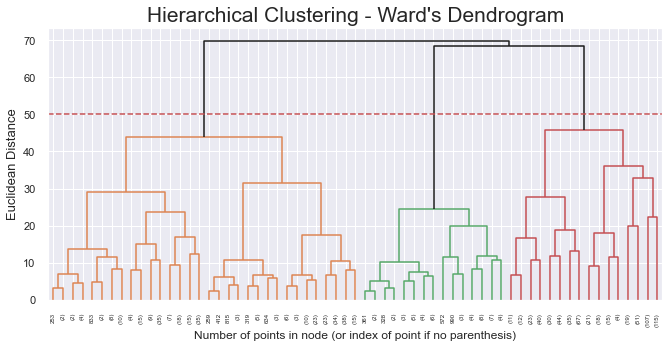

In [209]:
centroids_df_kmean = pd.DataFrame(kmeans_Hier_model.cluster_centers_, columns = PG_feats_numeric_final)
# Define full tree hierachical clustering to find the optimal number of clusters
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit(centroids_df_kmean)
# Plot the dendogram of the full tree
dendogram_hclust(hclust)

We can conclude that there are clearly 3 clusters observed in the dendrogram. Thus, we will go with 3 clusters in this model

In [210]:
# 3 cluster solution
hc3lust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
hc3_labels = hc3lust.fit_predict(centroids_df_kmean)
# Get labels of kmeans
df_km_hc_final = pd.concat([df_scaled, pd.Series(kmeans_Hier_model.labels_, index = df_scaled.index, name='KMlabels')],axis = 1)
# Get labels of hierachical
df_km_hc_final = df_km_hc_final.merge(pd.Series(hc3_labels, name='labels') , left_on='KMlabels', right_index=True)

R2 score of the "KMeans & Hierachical" cluster solution: 0.19509032692797323


<AxesSubplot:xlabel='labels', ylabel='count'>

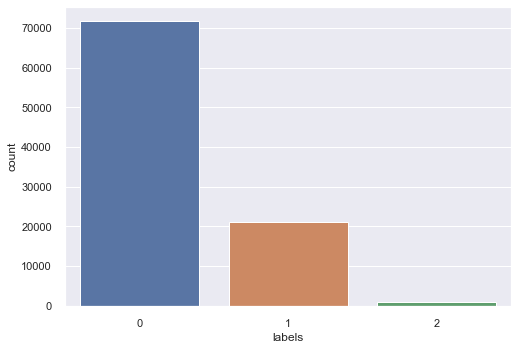

In [211]:
# Get R2 score of final cluster solution
print('R2 score of the "KMeans & Hierachical" cluster solution:',
      r2(df_km_hc_final[PG_feats_numeric_final],df_km_hc_final['labels']))
      
sns.countplot(x = df_km_hc_final['labels'])

- The size of each cluster is not well distributed. Despite the dendogram from hierachical clustering showed a considerably good distance from each clusters. It seemed like the clusters number 0 dominated the dataset while cluster number 2 does not have a significant number of representatives.  
- Moreover, R2 of only 0.1951 is not showing a good result comparing to KMeans model individually (0.4).  

Therefore, we will not consider this method in our cluster solution.    
**Nonetheless, we are able to strengthen our decision on the number of clusters (3 clusters) using this method.**

### 4.4.4. Final clustering solution and visualize result:

Since KMeans has outperformed other clustering solution regarding both R2, clusters' size and silhouette coeefiction, we will choose KMeans as our final clustering model for the Donor behavior cluster analysis

In [87]:
kmeans_model_final = KMeans(n_clusters=3, n_init=15, max_iter=300, tol=0.0001, random_state=2)
kmeans_model_final.fit(df_scaled)

KMeans(n_clusters=3, n_init=15, random_state=2)

In [88]:
df_PG_final = pd.concat([df, pd.Series(kmeans_model_final.labels_,index = df.index, name = 'PG_labels')],axis =1 )

<AxesSubplot:xlabel='PG_labels', ylabel='count'>

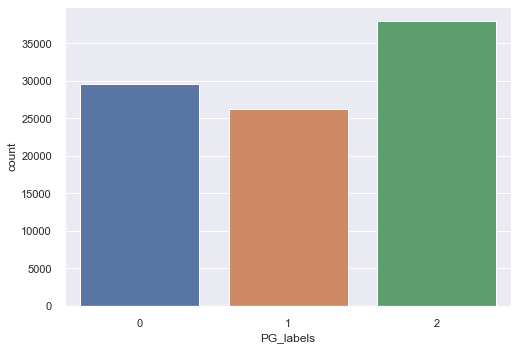

In [89]:
sns.countplot(x = df_PG_final['PG_labels'])

Size of each cluster is equally distributed

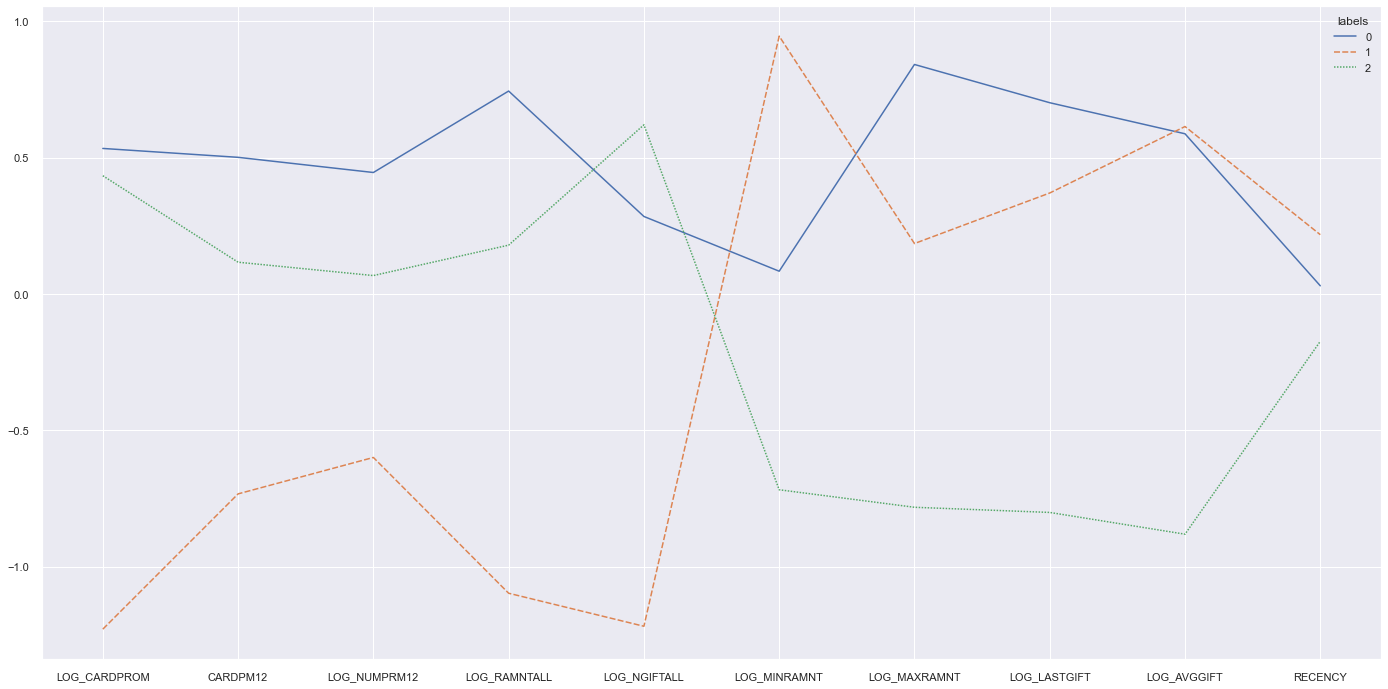

In [196]:
meanplot_df(df_scaled,df_PG_final['PG_labels'] )

- <font color='blue'>**Cluster 0: The Loyal Donor**</font>
  - Receive very high number of card promotion since the first date. They also receive the most number of promotions and card promotions in the current/last year. They can be the most senior people who had donated since the very first date of the organization
  - These donors have the highest value of donation without having the most number of donating times. They also have the highest value regarding to the maximum donation amount. This also make sense with the value of their average gift which is also one of the highests.  
  
        
- <font color='orange'>**Cluster 1: The Rising Donor**</font>
  - Receive very small number of promotion cards since their first time donation, this could be because of they had started donated recently. However, they also receive a relatively small number of promotion this year. This could be because they are not very active donor, so the association does not send them too much cards
  - Despite the total amount of donation and total number of gifts is low. They have the highest score in term of average amount of gifts. This infomation also comfirm our previous analysis that they started to donate much later than the others
  - These donors also have the highest for the amount of minimum gift. Our intepretation in this case is that because they do not donate a lot of time, so everytime they donate, the amount is fairly higher than other people who donate more in term of frequency 
  
  
- <font color='green'>**Cluster 2: The Active Donor**</font>  
  - Having the highest number of donation. They are also very active in term of receiving promotion and respond to these promotions
  - The value of each donation is relatively small but on the other hand, they donate very frequently


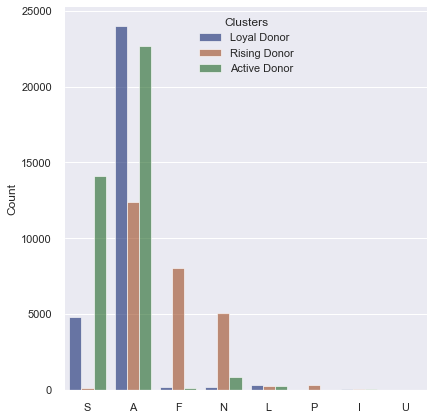

In [197]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_USEDTO_R", hue="PG_labels",
    ci="sd", palette="dark", alpha=.6, height=6,legend_out=False
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("Clusters")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
plt.show()

- F=FIRST TIME DONOR - Anyone who has made their first donation in the last 6 months and has made just one donation.

- N=NEW DONOR - Anyone who has made their first donation in the last 12 months and is not a First time donor.  This is everyone who made their first donation 7-12 months ago, or people who made their first donation between 0-6 months ago and have made 2 or more donations.

- A=ACTIVE DONOR - Anyone who made their first donation more than 12 months ago and has made a donation in the last 12 months.

- L=LAPSING DONOR - A previous donor who made their last donation between 13-24 months ago.

- I=INACTIVE DONOR - A previous donor who has not made a donation in the last 24 months. It is people who made a donation 25+ months ago.

- S=STAR DONOR STAR - Donors are individuals who have given to 3 consecutive card mailings.

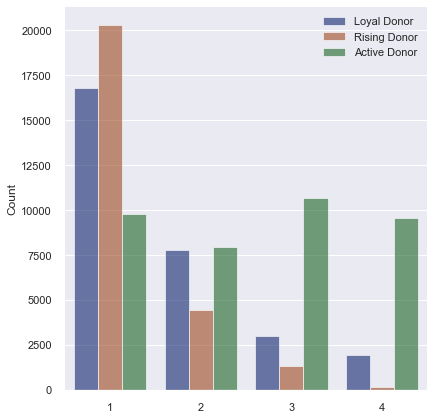

In [201]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_2F", hue="PG_labels",
    ci="sd", palette="dark", alpha=.6, height=6, legend_out=False
)
g.despine(left=True)
g.set_axis_labels("", "Count")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
g.legend.set_title("")

1=One gift in the period of recency  
2=Two gift in the period of recency  
3=Three gifts in the period of recency  
4=Four or more gifts in the period of recency  

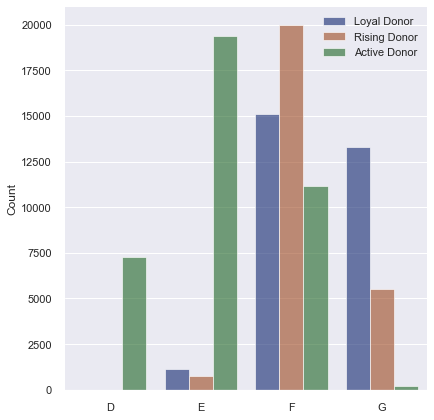

In [208]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_2A", hue="PG_labels",order=['D','E','F','G'],
    ci="sd", palette="dark", alpha=.6, height=6, legend_out=False
)
g.despine(left=True)

g.set_axis_labels("", "Count")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
g.legend.set_title("")

Third byte of the code is the Amount of the last gift.  

                            A=$0.01  -  $1.99  
                            B=$2.00  -  $2.99  
                            C=$3.00  -  $4.99  
                            D=$5.00  -  $9.99  
                            E=$10.00 - $14.99  
                            F=$15.00 - $24.99  
                            G=$25.00 and above  

<AxesSubplot:xlabel='AGE', ylabel='Density'>

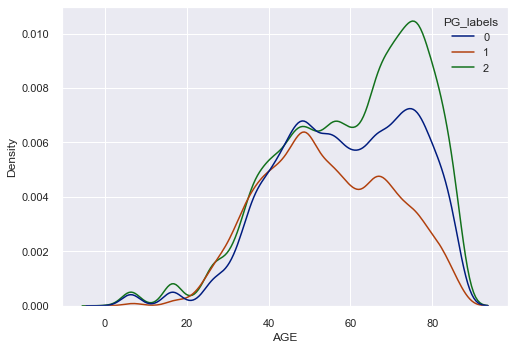

In [190]:
sns.kdeplot(data=df_PG_final, 
             x="AGE", hue="PG_labels",
             palette="dark")

<AxesSubplot:xlabel='INCOME', ylabel='Density'>

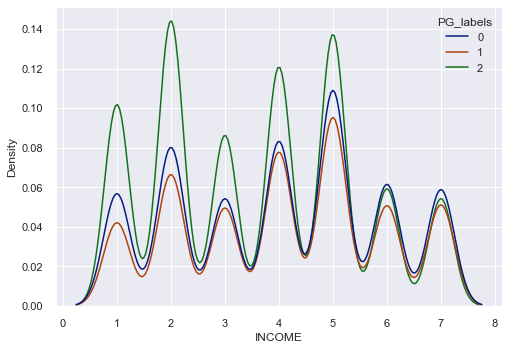

In [191]:
sns.kdeplot(data=df_PG_final, 
             x="INCOME", hue="PG_labels",
             palette="dark")

In [209]:
pca_combined = PCA_combined(df_scaled)
pca_combined.PCA_test(n_components = 4)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
LOG_CARDPROM,-0.816742,0.392666,-0.328148,-0.007182
CARDPM12,-0.463908,0.519378,0.458389,-0.460749
LOG_NUMPRM12,-0.424839,0.560173,0.575715,-0.187444
LOG_RAMNTALL,-0.629445,0.644695,-0.334668,0.182131
LOG_NGIFTALL,-0.911742,0.201017,-0.278085,0.134337
LOG_MINRAMNT,0.835493,0.224543,0.135435,-0.027366
LOG_MAXRAMNT,0.463151,0.804093,-0.151867,0.122518
LOG_LASTGIFT,0.585057,0.665854,-0.198104,0.010608
LOG_AVGGIFT,0.730981,0.634832,-0.010692,0.073604
RECENCY,0.262241,-0.095039,-0.740052,-0.594919


<AxesSubplot:xlabel='PC0', ylabel='PC1'>

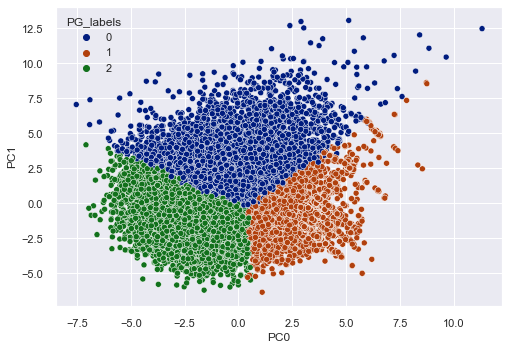

In [201]:
sns.scatterplot(x='PC0',
                y='PC1',
                data=pca_combined.pca_df_,
                palette="dark",
                hue = df_PG_final['PG_labels'])

# 4.3 Mail response features

The following variables indicate the number of known times the donor has responded to other types of mail order offers.
- MBCRAFT                   -   Buy Craft Hobby
- MBGARDEN                 -   Buy Gardening
- MBBOOKS                   -   Buy Books
- MBCOLECT                 -   Buy Collectables
- MAGFAML                   -   Buy General Family Mags
- MAGFEM                     -   Buy Female Mags
- MAGMALE                   -   Buy Sports Mags
- PUBGARDN                 -   Gardening Pubs
- PUBCULIN                 -   Culinary Pubs
- PUBHLTH                  -   Health Pubs
- PUBDOITY                 -   Do It Yourself Pubs
- PUBNEWFN                 -   News / Finance Pubs
- PUBPHOTO                 -   Photography Pubs
- PUBOPP                   -   Opportunity Seekers Pubs

From the above information about the features, it would be interesting to investigate about the association rules regarding to the offers by mail. The result of this analysis can be useful when designing the marketing campaign


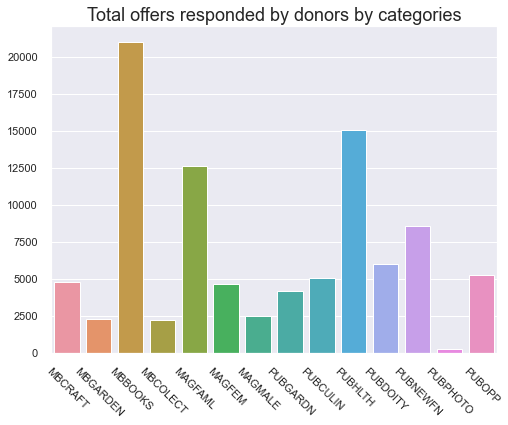

In [92]:
totalOffered = (np.sum((df[mail_feats].dropna() > 0),axis = 0))

fig, ax = plt.subplots(figsize = (8,6))
g = sns.barplot(x = totalOffered.index, y = totalOffered.values)
plt.xticks(rotation=-45)
plt.title('Total offers responded by donors by categories',fontsize = 18)
plt.show()

In [93]:
df[mail_feats].dropna()

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,
148535,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
15078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
172556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7112,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
109359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35088,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


## 4.3.1. Association rules:

Firstly, we will drop the null values and convert the data into binary for the process of computing association rules' measures

In [107]:
# Drop null values
df_mailfeats = df[mail_feats].dropna()
df_mailfeats

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,
148535,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
15078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
172556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7112,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
109359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35088,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [113]:
# https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
from mlxtend.frequent_patterns import apriori, association_rules
# delete the donors that do not response to any offer
df_offer_responded = df_mailfeats.loc[np.sum((df[mail_feats].dropna() > 0),axis = 1) != 0,:] > 0

freq_items = apriori(df_offer_responded, min_support=0.2, use_colnames=True, verbose=1)
freq_items.sort_values(by = ['support'],ascending=False)
#fig, ax = plt.subplots(figsize = (10,6))
#g = sns.barplot(x = 'itemsets', y = 'support', data=freq_items.sort_values(by = ['support'],ascending=False),ax=ax)
#plt.xticks(rotation=-45)
#plt.show()

Processing 9 combinations | Sampling itemset size 3


,support,itemsets
0,0.694035,(MBBOOKS)
2,0.496495,(PUBHLTH)
1,0.417168,(MAGFAML)
5,0.402652,"(MBBOOKS, PUBHLTH)"
4,0.292573,"(MBBOOKS, MAGFAML)"
3,0.282488,(PUBNEWFN)
6,0.221017,"(MBBOOKS, PUBNEWFN)"


`MAGFAML`, `MBBOOKS` and `PUBHLTH` are usually bought together

In [114]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(MAGFAML),(MBBOOKS),0.417168,0.694035,0.292573,0.701332,1.010514,0.003044,1.024431
1,(MBBOOKS),(PUBHLTH),0.694035,0.496495,0.402652,0.580161,1.168513,0.058067,1.199281
2,(PUBHLTH),(MBBOOKS),0.496495,0.694035,0.402652,0.810989,1.168513,0.058067,1.618769
3,(PUBNEWFN),(MBBOOKS),0.282488,0.694035,0.221017,0.782395,1.127314,0.024961,1.406057


Rule of `PUBHLTH` -> `MBBOOKS` have the highest confidence of being bought together

## 4.3.2. K-Means clustering with characteristics features:

In [126]:
# Check for data availability of characteristics features with the donors who responded to mail offers
df.loc[df_mailfeats.index,char_feats].isna().sum()

ODATEDW         0
OSOURCE       431
TCODE           0
STATE           0
ZIP             0
DOMAIN        863
HOMEOWNR      497
NUMCHLD     34769
INCOME          0
GENDER          0
WEALTH1         0
HIT             0
WEALTH2     17526
GEOCODE     34232
GEOCODE2        9
AGE          4376
dtype: int64

We will analyse the characteristics of donors that responsed to mail offers on the features that do not having too many null values: `INCOME`, `HOMEOWNR`, ` GENDER`, `WEALTH1` and `HIT`

In [130]:
df_m_ch = df_mailfeats.merge(df.loc[df_mailfeats.index, ['INCOME', 'HOMEOWNR', 'GENDER', 'WEALTH1', 'HIT', 'AGE']],left_index=True, right_index=True)

In [131]:
df_m_ch.isna().sum()

MBCRAFT        0
MBGARDEN       0
MBBOOKS        0
MBCOLECT       0
MAGFAML        0
MAGFEM         0
MAGMALE        0
PUBGARDN       0
PUBCULIN       0
PUBHLTH        0
PUBDOITY       0
PUBNEWFN       0
PUBPHOTO       0
PUBOPP         0
INCOME         0
HOMEOWNR     497
GENDER         0
WEALTH1        0
HIT            0
AGE         4376
dtype: int64

There are number of missing values remained, we will exclude them out now and do the clustering on the available data

In [153]:
# Save the index of missing values for later imputing
NA_offers_char = df_m_ch.isna().index
# Drop rows having missing values:
df_m_ch_drNA = df_m_ch.dropna(axis = 0)
#
categorical = df_m_ch_drNA.loc[:,df_m_ch_drNA.dtypes == 'O'].columns
numeric = df_m_ch_drNA.loc[:,df_m_ch_drNA.dtypes != 'O'].columns

In [164]:
# Scale the data with standard scaler
df_m_ch_drNA_scaled = pd.DataFrame(StandardScaler().fit_transform(df_m_ch_drNA[numeric]),index = df_m_ch_drNA[numeric].index, columns=numeric)

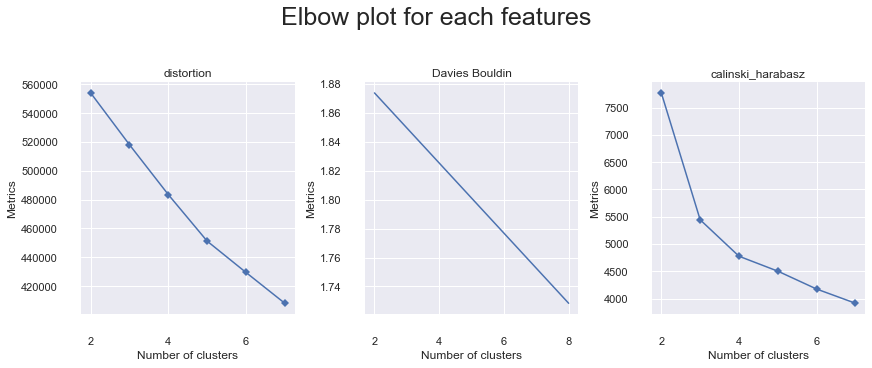

In [165]:
# plot the elbow plot
clusters_score(df_m_ch_drNA_scaled)

In [178]:
kmeans_model_final = KMeans(n_clusters=3, n_init=15, max_iter=300, tol=0.0001, random_state=2)
kmeans_model_final.fit(df_m_ch_drNA_scaled)

KMeans(n_clusters=3, n_init=15, random_state=2)

In [179]:
df_m_ch_final = pd.concat([df_m_ch_drNA_scaled, 
                           pd.Series(kmeans_model_final.labels_,index = df_m_ch_drNA_scaled.index, name = 'm_ch_labels')],axis =1 )

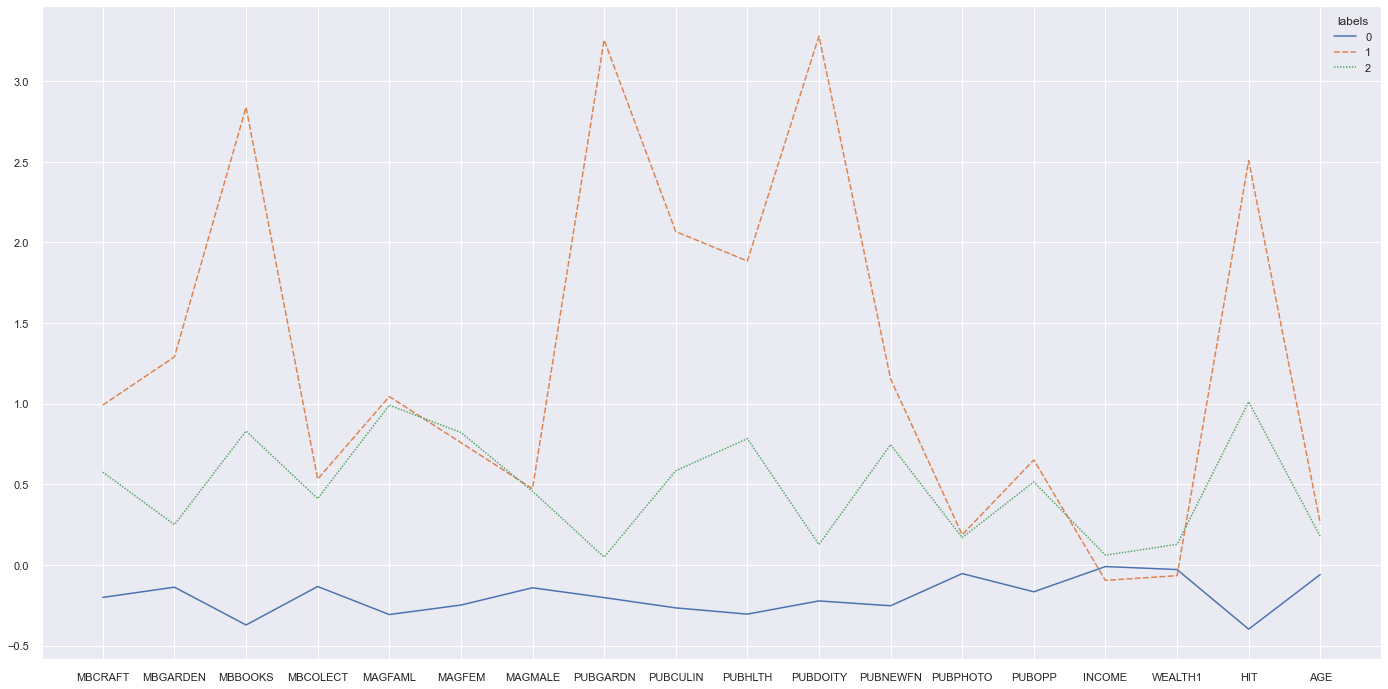

In [180]:
meanplot_df(df_m_ch_drNA_scaled, kmeans_model_final.labels_ )

<AxesSubplot:xlabel='m_ch_labels', ylabel='count'>

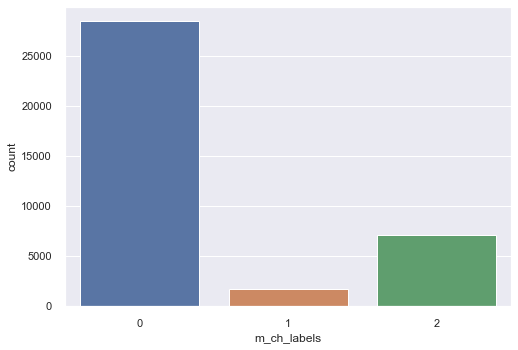

In [185]:
sns.countplot(x = df_m_ch_final['m_ch_labels'])

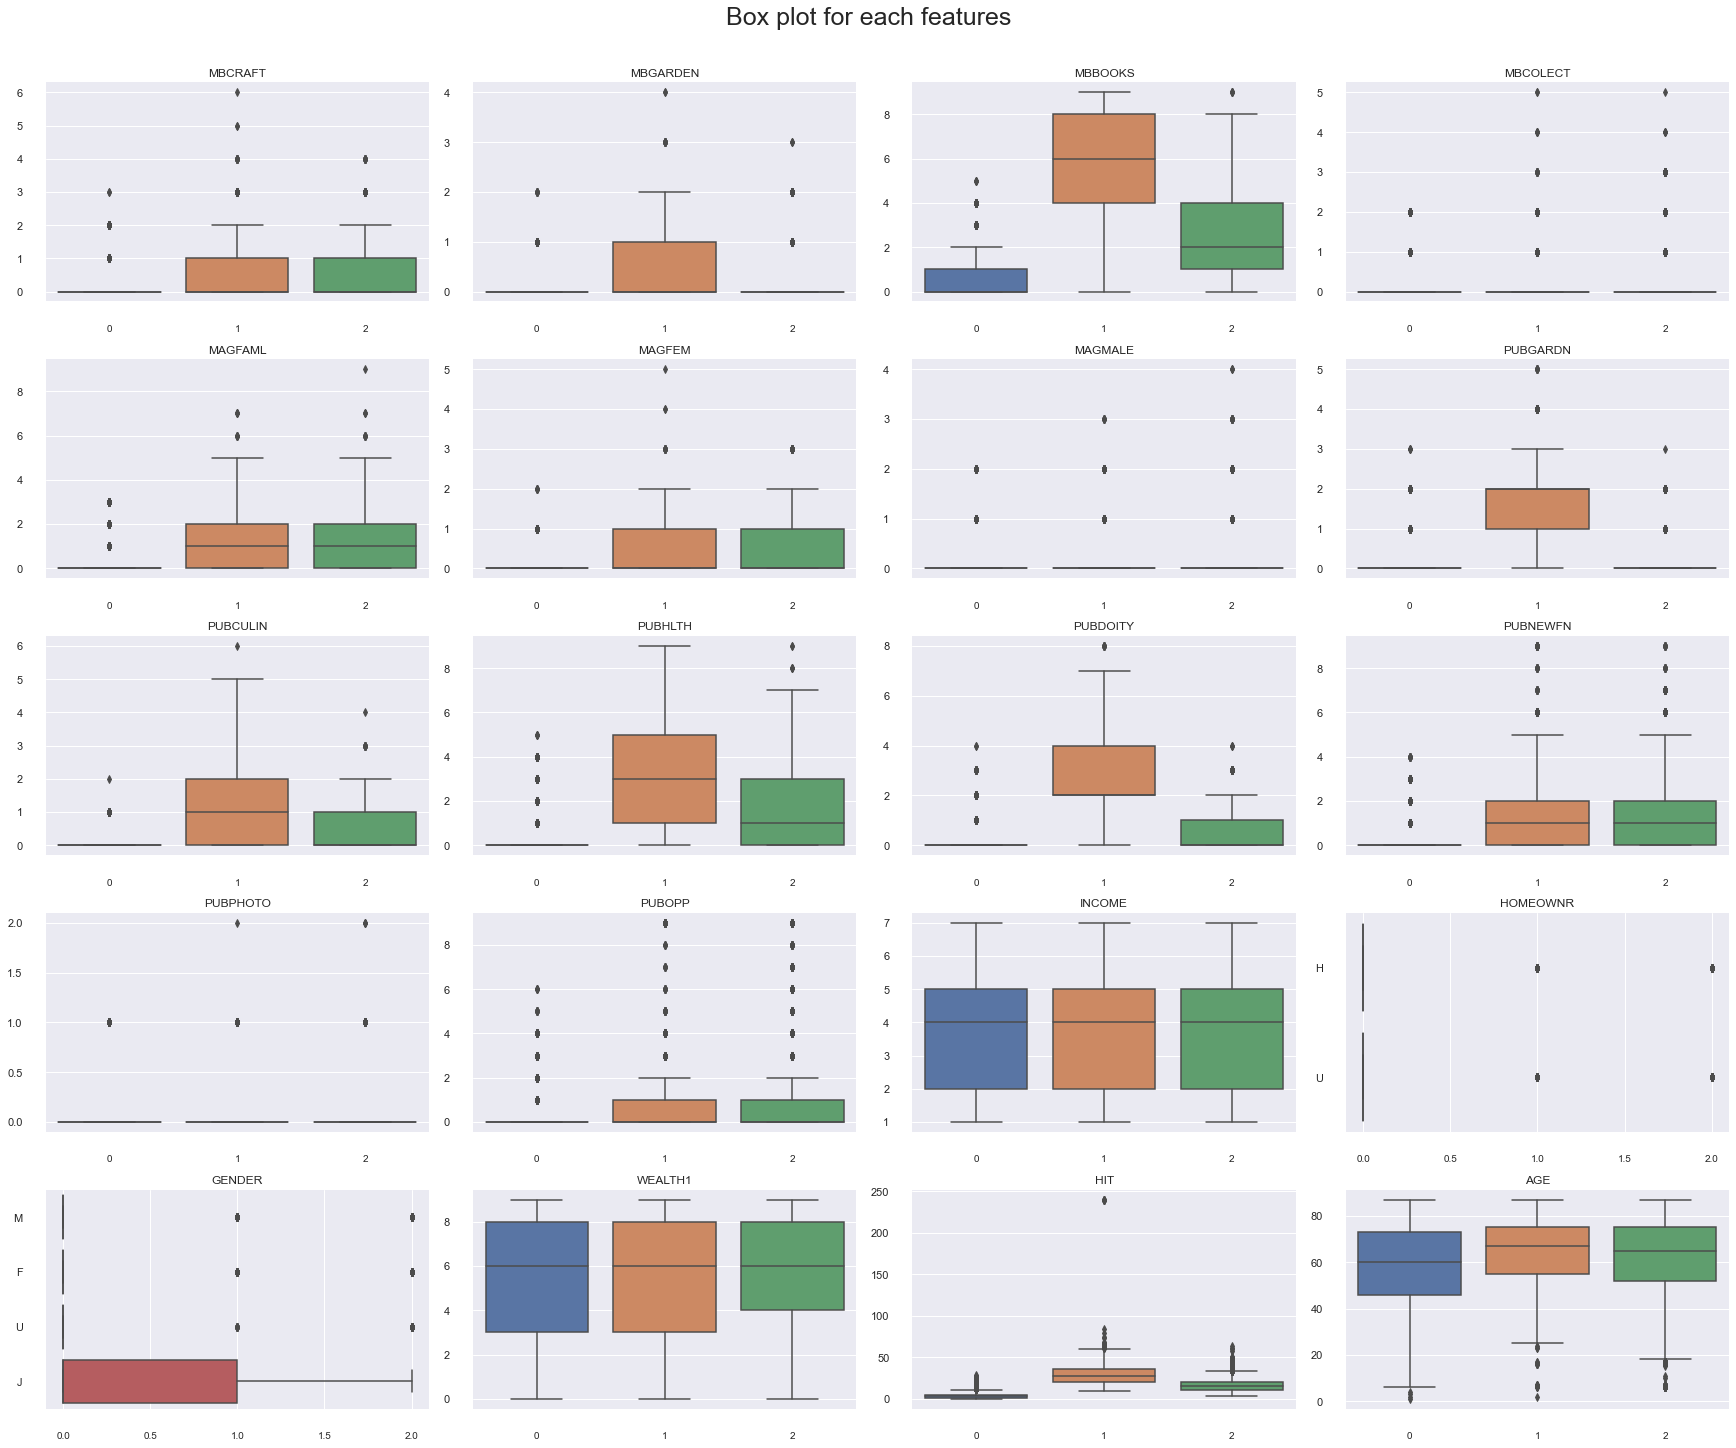

In [184]:
boxplot_df(df_m_ch_drNA, kmeans_model_final.labels_)

# 6. Merging the Perspectives
- How can we merge different cluster solutions?

In [12]:
# Product: K = 3
# Behavior: K = 4

kmeans_prod = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_prod.fit_predict(df_prf)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [13]:
# Count label frequencies
df.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,639,1331,207
1,1456,1162,1014
2,246,708,43
3,1229,387,293
